In [35]:
import seaborn as sns
import pylab as pl
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm
import pickle
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from scipy.ndimage.filters import gaussian_filter
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
from matplotlib.transforms import Affine2D

from statannot import add_stat_annotation

import mpl_toolkits.axisartist.floating_axes as floating_axes
from matplotlib.patches import Patch, Ellipse

import scipy.spatial.distance as sp_dist
import scipy.stats as sp_st
import matplotlib.pyplot as plt
import math

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

import sys
sys.path.append('/home/jyotika/Utils/hddm/')

import hddm

/tmp/ipykernel_503498/1252002088.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
# Change the data directory path

data_dir_reg1 = "../churchland_code/Data/GA/Cx_D1_mostly_positive/" #" wo_corticostriatal/"
figure_dir = "../churchland_code/Figures/"

data_dir_reg1_on = "../churchland_code/Data/GA/Cx_D1_mostly_positive/"
data_dir_reg2_on = "../Data/"
data_dir_reg2 = "../churchland_code/Data/GA/"
data_dir_reg21 = "../churchland_code/Data/GA/o_f_f/"

plt.rcParams["figure.facecolor"] = "w"

sns.set(style='white',font_scale=2.5)

In [3]:
exp_type1 = "lhs_Cx_D1_pve"
coding = "off"
ddm_params = ["a","t","v","z"]

In [4]:
nw_types = ["Fast","Intermediate","Slow"]
markers =["o","X"]
markers_regime = ['D',"P"]
plasticity_status = ["before_plasticity","after_plasticity"]
regimes = ["Cx_BG_driven", "Cx_Th_driven"]

col1 = sns.color_palette()[:]
colors = [col1[1],col1[5],col1[3]]

colors_nw = dict()
for i,nt in enumerate(nw_types):
    colors_nw[nw_types[i]] = colors[i]

markers_nw = dict()
for i,nt in enumerate(markers):
    markers_nw[plasticity_status[i]] = markers[i]

markers_reg = dict()
for i,nt in enumerate(regimes):
    markers_reg[nt] = markers_regime[i]

In [5]:
regime = "asymmetric"

a_range = np.round(np.linspace(0.1,0.65,15),2)
v_range = np.round(np.linspace(-0.015,11.0,15),2)
t_range = np.round(np.linspace(0.01,0.1,15),2)

a_range_dat = np.round(np.linspace(0.01,1.3,10),2)
v_range_dat = np.round(np.linspace(-0.015,20.0,10),2)
t_range_dat = np.round(np.linspace(0.01,0.15,10),2)

In [25]:
RTs = pd.read_csv(data_dir_reg2_on+"simulated_data_ddm_RTs_test3_"+regime+".csv")
response = pd.read_csv(data_dir_reg2_on+"simulated_data_ddm_accuracy_test3_"+regime+".csv")
rt_dist_from_optimal_all_nws = pickle.load(open(data_dir_reg1_on+"rt_dist_from_optimal_all_nws"+postfix+".pickle","rb"))
acc_dist_from_optimal_all_nws = pickle.load(open(data_dir_reg1_on+"acc_dist_from_optimal_all_nws"+postfix+".pickle","rb"))
rr_dist_from_optimal_all_nws = pickle.load(open(data_dir_reg1_on+"rr_dist_from_optimal_all_nws"+postfix+".pickle","rb"))

In [7]:
combine_regimes_off_and_on = pd.read_csv(data_dir_reg1_on+"combined_regimes_off_on_fig2.csv")

In [26]:
def setup_axes1(fig, rect, angle,scale,aspect,tit,fs,with_ticklabs=True):
    plt.rcParams['axes.labelsize'] = fs
    plt.rcParams["svg.fonttype"] ='none'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20

    tr = Affine2D().scale(2/aspect, 2).rotate_deg(angle)
    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=scale) #, tick_formatter1= DictFormatter(dictio),

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    
    ax1.set_ylabel("boundary height (a)",rotation=180)
    ax1.set_xlabel("drift rate (v)")
    for x in ax1.get_xticklabels():
        x.set_fontsize(20)

    for x in ax1.get_yticklabels():
        x.set_fontsize(20)
    
    print("fs",fs)
    print(with_ticklabs)
    if with_ticklabs == False:
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    fig.add_subplot(ax1)

    

    aux_ax = ax1.get_aux_axes(tr)
    for x in aux_ax.get_xticklabels():
        x.set_fontsize(20)

    for x in aux_ax.get_yticklabels():
        x.set_fontsize(20)

   
    return aux_ax

def get_2d_map(data,feat):
    x = np.round(data["v"].values,2)
    y = np.round(data["a"].values,2)
    z = np.round(data["t"].values,2)
    if isinstance(feat,str):
        val = data[feat].values
    else:
        val = np.copy(feat)
   
    XY_f = np.zeros((len(v_range),len(a_range)))
    for i,(a,b,f) in enumerate(zip(x,y,val)):
        ind_x = np.digitize(a,v_range)-1
        ind_y = np.digitize(b,a_range)-1
        XY_f[ind_x,ind_y] = f
    
    return XY_f


def return_contours(XY,v_range,a_range,min_or_max="min",feat_name="RT",postfix="minimum",prev_pts=[],next_pts=[]):
    XY_smooth = gaussian_filter(XY, 0.1)
    min_z = np.percentile(XY_smooth.ravel(),5)
    max_z = np.percentile(XY_smooth.ravel(),95)
    fig = pl.figure()
    ax0 = fig.add_subplot(111,aspect=np.max(v_range)/np.max(a_range))
    im= ax0.contourf(v_range,a_range,XY_smooth.T,cmap='viridis',shading='gouraud',alpha=0.2,vmin=min_z,vmax=max_z)
    if min_or_max == "min":
        st,en = im.levels[0], im.levels[1]
    elif min_or_max == "max":
        st,en = im.levels[-2], im.levels[-1]
    X_level = XY_smooth[(XY_smooth>=st)&(XY_smooth<=en)]
    mean_z = np.mean(X_level)
    print("target z",mean_z)
    ind_z = np.where(np.abs(XY_smooth - mean_z)<0.0005)
    print("ind_z",ind_z)
    
    max_v = np.max(v_range)
    max_a = np.max(a_range)
    
    if postfix == "artificial":
        if feat_name == "RT":
            max_rr_a = 0.28
            max_rr_v = 9.0
        elif feat_name == "P(L)":
            max_rr_a = 0.56
            max_rr_v = 9.0
        elif feat_name == "RR":
            max_rr_v = 9.2
            max_rr_a = 0.32
    elif postfix == 'minimum' or postfix == "maximum":
        if len(ind_z) > 1:
            ind_z1 = np.array([ind_z[0][0],ind_z[1][0]])
        else:
            ind_z1 = ind_z
            print("ind_z",ind_z1)
        max_rr_a = a_range[ind_z1[1]]
        max_rr_v = v_range[ind_z1[0]]

    elif postfix == "local":
        next_pts_n = np.array([next_pts[0]/max_v, next_pts[1]/max_a])
        prev_pts_n = np.array([prev_pts[0]/max_v, prev_pts[1]/max_a])
        
        rad = np.round(np.linalg.norm(next_pts_n-prev_pts_n),4)

        circle_points = []                # v_n = v/max_v
                # a_n = a/max_a

        for i,v in enumerate(v_range):
            for j,a in enumerate(a_range):
                v_n = v/max_v
                a_n = a/max_a
                r_check = np.round(np.sqrt((v_n - prev_pts_n[0])**2 + (a_n - prev_pts_n[1])**2),4)

                diff =rad-r_check 
                circle_points.append([(v,a),np.abs(diff),np.round(XY_smooth[i,j],2)])        
        
        
        ind_sort = np.argsort(np.array(circle_points)[:,1])
        sorted_cp = np.array(circle_points)[ind_sort][:20]
        
        if min_or_max == 'min':
            ind_sort1 = np.argsort(sorted_cp[:,2])
        elif min_or_max == 'max':
            ind_sort1 = np.argsort(sorted_cp[:,2])[::-1]
        # = np.array(circle_points)
        sorted_cp1 = sorted_cp[ind_sort1]
        

        print("circle points",sorted_cp1)
        max_rr_v = sorted_cp1[0][0][0]
        max_rr_a = sorted_cp1[0][0][1]
            
    
    print(max_rr_v, max_rr_a)
    return (max_rr_v, max_rr_a)
    


def plot_background_contour_rotated(X,Y,XY,v_range,a_range,tit,with_cbar=True,fs=30,with_ticklabs=False):

    fig = pl.figure(figsize=(12.5,12.5))
    
    ax0 = setup_axes1(fig,111,45,((0.01,np.max(v_range),0.1,np.max(a_range))),np.max(v_range)/(np.max(a_range)-0.1),tit,fs,with_ticklabs)
    for x in ax0.get_xticklabels():
        x.set_fontsize(20)

    for x in ax0.get_yticklabels():
        x.set_fontsize(20)


    XY_smooth = gaussian_filter(XY, 0.05)
    min_z = np.percentile(XY_smooth.ravel(),5)
    max_z = np.percentile(XY_smooth.ravel(),95)
    
    im1 = ax0.contourf(X,Y,XY_smooth.T,cmap='viridis',shading='gouraud',alpha=0.2,vmin=min_z,vmax=max_z)

    #CS2 = ax0.contour(im1, levels=im1.levels[::2], colors='k')
    CS2 = ax0.contour(X,Y,XY_smooth.T,levels=im1.levels[::2], colors='k')
    ax0.clabel(CS2, fmt='%2.1f', colors='k', fontsize=14)
    ax0.set_ylim(np.min(a_range),np.max(a_range))
    
        
    
    if with_cbar == True:
        cbar_ax = fig.add_axes([0.1, 0.8, 0.3, 0.05])
        fig.colorbar(im1, cax=cbar_ax,orientation='horizontal')
        if tit == "P(L)":
            tit = "Accuracy"
        elif tit == "RT":
            tit = "RT"
        cbar_ax.set_title(tit,fontsize=25,fontweight='bold')
        for i,x in enumerate(cbar_ax.get_xticklabels()):
            if i%2 == 0:
                x.set_fontsize(20)
            else:
                x.set_visible(False)
        
    
    return fig,ax0



def distance_vectors(v1,v2,dist_type='cosine'):
    
    # find angle between the vectors
    if dist_type == "cosine":
        angle = math.degrees(math.acos(np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))))
        print("angle",angle)
        cos_dist = math.cos(math.radians(angle))
        print("cos_dist",cos_dist)
        dist = 1 - cos_dist
    elif dist_type == "euclidean":
        dist = sp_dist.euclidean(v1,v2)
    return dist
    
    

def plot_step_by_step_trajectory(ddm_params_stepwise,to_plot,ax0,fig,XY,v_range,a_range,min_or_max,feat_name,postfix):    

    stages = ["before_plasticity","after 2 plasticity trials","after 4 plasticity trials","after 6 plasticity trials","after 15 plasticity trials"]#"after_plasticity"]#"after 15 plasticity trials"]

    if postfix != "local":
        target_v, target_a  = return_contours(XY,v_range,a_range,min_or_max,feat_name,postfix)
        print("target",(target_v,target_a))

    indices_nw_type = dict({'Fast':1,'Intermediate':5,'Slow':2})
    nbins = 4
    
    b4_plas = to_plot.loc[(to_plot["plasticity_status"]=="before_plasticity")&(to_plot["regime"]=="Cx_BG_driven") &(to_plot["seed"].isin(list(ddm_params_stepwise["seed"].unique())))].copy()
    aft_plas = to_plot.loc[(to_plot["plasticity_status"]=="after_plasticity")&(to_plot["regime"]=="Cx_BG_driven")].copy()
    
    
   
    
    for grp in b4_plas.groupby(["network_type"]):
        x_mean = grp[1]["v"].median()
        y_mean = grp[1]["a"].median()
        col_key = grp[0]

        ax0.plot(x_mean,y_mean,color=colors_nw[col_key],ms=15,marker='*',markeredgewidth=2.0)

        temp = ddm_params_stepwise.loc[(ddm_params_stepwise["network_type"]==grp[0])][["regime","seed"]]
        temp["a"] = y_mean
        temp["v"] = x_mean
        temp["state"] = "before_plasticity"
        temp["network_type"] = grp[0]
        ddm_params_stepwise = ddm_params_stepwise.append(temp)

        if postfix != "local":
            ax0.plot(target_v,target_a,color='k',ms=15,marker='s',markeredgewidth=2.0)
        


    ddm_params_stepwise_sub = ddm_params_stepwise.loc[(ddm_params_stepwise["network_type"].isin(["Fast","Intermediate","Slow"]))&(ddm_params_stepwise["state"]!="before plasticity")].copy()

    
    a,bins = np.histogram(ddm_params_stepwise_sub.dropna().avg_rpe.values,bins=nbins)
    cmap1 = cm.get_cmap('cool',nbins+1)
    colors_cmap = [ cmap1(i)  for i in np.arange(nbins+1)]
                
    ddm_params_stepwise_sub_temp = ddm_params_stepwise_sub.copy()#loc[~ddm_params_stepwise_sub["seed"].isin([])]#,34468,34422,34467,34383,34450,34351,34404])]


    distance_from_optimal = dict()
    
    print(feat_name)
    print("========================================================")
    for grp in ddm_params_stepwise_sub_temp.groupby("network_type"):
        col_key = grp[0]
        print(grp[0])
        if grp[0] not in list(distance_from_optimal.keys()):
            distance_from_optimal[grp[0]] = []
            
        
        x_last = aft_plas.loc[aft_plas["network_type"]==grp[0]]["v"].mean()
        y_last = aft_plas.loc[aft_plas["network_type"]==grp[0]]["a"].mean()
        
        x_err = np.std(aft_plas.loc[aft_plas["network_type"]==grp[0]]["v"])#list(np.abs(x_mean-np.array([np.percentile(grp[1]["v"],10), np.percentile(grp[1]["v"],90)])))
        y_err = np.std(aft_plas.loc[aft_plas["network_type"]==grp[0]]["a"])#list(np.abs(y_mean-np.array([np.percentile(grp[1]["a"],10), np.percentile(grp[1]["a"],90)])))

        
        for i,st in enumerate(stages[:-1]):
            sub_slice1 = grp[1].loc[grp[1]["state"]==st]
            sub_slice2 = grp[1].loc[grp[1]["state"]==stages[i+1]]
            x_prev = sub_slice1["v"].median()
            y_prev = sub_slice1["a"].median()
          
            
            if grp[0] == "Intermediate":
                v_offset = 1.2#1.6
                a_offset = 0.04
            elif grp[0] == "Slow":
                v_offset = 1.5#1.87
                a_offset = 0#-0.01
            else:
                v_offset = 0
                a_offset = 0
            print("offset",v_offset,a_offset)
            if "15" in stages[i+1]:
                print(grp[0],v_offset,a_offset)
                x_mean = sub_slice2["v"].median()+v_offset
                y_mean = sub_slice2["a"].median()+a_offset

            else:
                x_mean = sub_slice2["v"].median()
                y_mean = sub_slice2["a"].median()

            print("xmean,ymean",x_mean,y_mean)
            

            ax0.plot(x_mean,y_mean,marker=markers_reg['Cx_BG_driven'],color=colors_nw[col_key],ms=8,markeredgewidth=2.0,markeredgecolor='k')


            a1 = FancyArrowPatch((x_prev, y_prev ), (x_mean,y_mean)
                                 ,mutation_scale=20,
                                    lw=2.5, arrowstyle="->", color=colors_nw[col_key],ls='dashed' )
            ax0.add_artist(a1)
            if "15" in stages[i+1]:

                print("err",x_err,y_err)
                ells = Ellipse(xy=(x_last,y_last),width=x_err, height=y_err,facecolor=colors_nw[col_key],alpha=0.3)                
                ax0.add_artist(ells)


            if postfix== "local":
                target_v, target_a  = return_contours(XY,v_range,a_range,min_or_max,feat_name,postfix,np.array([x_prev,y_prev]),np.array([x_mean,y_mean]))
                print("target",(target_v,target_a))
                

            # find the level that the current point falls in 
            print("x,y",x_mean,y_mean)

            if i == 0: # and grp[0] == "Slow":
                ax0.plot(target_v,target_a,color='k',ms=5,marker='s',markeredgewidth=2.0)
                a1 = FancyArrowPatch((x_prev, y_prev ), (target_v,target_a)
                                     ,mutation_scale=20,
                                        lw=2.0, arrowstyle="->", color='dodgerblue',ls='dashed')
                
                ax0.add_artist(a1)
            
            # Angle between optimal path and actual path
            # Normalize all values by maximum in each dimension, so that the angle calculations are not affected by the range of x and y axis
            max_v = np.max(v_range)
            max_a = np.max(a_range)
            
            p0 = np.array([x_prev/max_v, y_prev/max_a])
            p_opt = np.array([target_v/max_v, target_a/max_a])
            p_act = np.array([x_mean/max_v, y_mean/max_a])

            
            
            print("p0, p_opt, p_act",p0,p_opt,p_act)
            
            v_opt = p_opt - p0
            v_act = p_act - p0

            

            cos_dist = sp_dist.cosine(v_opt,v_act)
            print("cos_dist",cos_dist)
            distance_from_optimal[grp[0]].append((stages[i+1], cos_dist))
                
                
    return distance_from_optimal                

def func_fill_df(feat_dict,feat_name):
    df = pd.DataFrame()
    for k in feat_dict.keys():
        temp = pd.DataFrame()
        temp["network_type"] = [k]
        for i in np.arange(len(feat_dict[k])):
            dat = feat_dict[k][i]
            #print(dat[0])
            temp["state"] = [dat[0]]
            temp["cosine distance"] = [dat[1]]
            df = pd.concat([df,temp])
    df["feature_name"] = feat_name
    return df

In [27]:
to_plot = combine_regimes_off_and_on[["a","v","t","RT","P(L)","network_type","plasticity_status","regime","seed"]].copy()
to_plot["RT"] = to_plot["RT"].values/1000.

x = RTs["v"].values
y = RTs["a"].values
z = RTs["t"].values
rts = RTs["RT"].values
accuracy = response["response"].values
reward_rate = response["response"].values/(RTs["RT"].values+z)

XY_rt = get_2d_map(RTs,"RT")
XY_accuracy = get_2d_map(response,"response")
XY_rr = get_2d_map(response,reward_rate)

X, Y = np.meshgrid(v_range, a_range)
X_data, Y_data = np.meshgrid(v_range_dat, a_range_dat)
 

In [28]:
ddm_params_stepwise = pd.read_csv(data_dir_reg1+"ddm_parameters_step_plasticity.csv")
ddm_params_stepwise["regime"] = "Cx_BG_driven"

fs 30
False
RT
Fast
offset 0 0
xmean,ymean 5.999948173163823 0.2877822321907657
target z 0.07752968108681679
ind_z (array([14, 14]), array([1, 2]))
circle points [[(5.49, 0.14) 0.014599999999999946 0.08]
 [(5.49, 0.18) 0.03320000000000001 0.09]
 [(6.28, 0.3) 0.027200000000000002 0.1]
 [(6.28, 0.22) 0.026699999999999946 0.1]
 [(6.28, 0.26) 0.023499999999999965 0.1]
 [(5.49, 0.34) 0.032200000000000006 0.11]
 [(5.49, 0.38) 0.0131 0.11]
 [(5.49, 0.41) 0.00539999999999996 0.12]
 [(4.71, 0.45) 0.023900000000000032 0.12]
 [(5.49, 0.45) 0.03510000000000002 0.12]
 [(4.71, 0.49) 0.014499999999999957 0.12]
 [(5.49, 0.1) 0.010399999999999965 0.12]
 [(3.92, 0.53) 0.009199999999999986 0.14]
 [(3.13, 0.53) 0.03260000000000002 0.14]
 [(3.13, 0.57) 0.020399999999999974 0.15]
 [(2.35, 0.57) 0.010000000000000009 0.16]
 [(1.56, 0.57) 0.032200000000000006 0.16]
 [(1.56, 0.61) 0.027699999999999947 0.18]
 [(0.77, 0.61) 0.016599999999999948 0.18]
 [(-0.02, 0.61) 0.014900000000000024 0.19]]
5.49 0.14
target (5

/tmp/ipykernel_503498/1312275255.py:154: UserWarning: The following kwargs were not used by contour: 'shading'
  im1 = ax0.contourf(X,Y,XY_smooth.T,cmap='viridis',shading='gouraud',alpha=0.2,vmin=min_z,vmax=max_z)
/tmp/ipykernel_503498/1312275255.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ddm_params_stepwise = ddm_params_stepwise.append(temp)
/tmp/ipykernel_503498/1312275255.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ddm_params_stepwise = ddm_params_stepwise.append(temp)
/tmp/ipykernel_503498/1312275255.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ddm_params_stepwise = ddm_params_stepwise.append(temp)
/tmp/ipykernel_503498/1312275255.py:65: UserWarning: The following kwargs were not used by co

target z 0.07752968108681679
ind_z (array([14, 14]), array([1, 2]))
circle points [[(3.92, 0.26) 0.06309999999999999 0.09]
 [(5.49, 0.3) 0.034 0.09]
 [(5.49, 0.26) 0.024400000000000005 0.09]
 [(6.28, 0.26) 0.0567 0.1]
 [(4.71, 0.3) 0.02940000000000001 0.1]
 [(3.92, 0.3) 0.0232 0.1]
 [(4.71, 0.26) 0.027099999999999985 0.1]
 [(6.28, 0.3) 0.014799999999999994 0.1]
 [(3.92, 0.34) 0.005099999999999993 0.1]
 [(6.28, 0.38) 0.009499999999999995 0.11]
 [(6.28, 0.34) 0.004900000000000002 0.11]
 [(6.28, 0.41) 0.037599999999999995 0.11]
 [(5.49, 0.38) 0.0432 0.11]
 [(4.71, 0.45) 0.061700000000000005 0.12]
 [(4.71, 0.38) 0.0379 0.12]
 [(3.92, 0.41) 0.044800000000000006 0.12]
 [(4.71, 0.41) 0.002999999999999989 0.12]
 [(5.49, 0.45) 0.059599999999999986 0.12]
 [(3.92, 0.38) 0.0184 0.12]
 [(5.49, 0.41) 0.0003000000000000086 0.12]]
3.92 0.26
target (3.92, 0.26)
x,y 6.3104325132223344 0.32912867517566047
p0, p_opt, p_act [0.46862716 0.52817182] [0.35636364 0.4       ] [0.57367568 0.50635181]
cos_dist 1.

/tmp/ipykernel_503498/1312275255.py:65: UserWarning: The following kwargs were not used by contour: 'shading'
  im= ax0.contourf(v_range,a_range,XY_smooth.T,cmap='viridis',shading='gouraud',alpha=0.2,vmin=min_z,vmax=max_z)
/tmp/ipykernel_503498/1312275255.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ind_sort = np.argsort(np.array(circle_points)[:,1])
/tmp/ipykernel_503498/1312275255.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sorted_cp = np.array(circle_points)[ind_sort][:20]
/tmp/ipykernel_503498/1312275255.py:65: UserWarning: The

target z 0.9846836734693879
ind_z (array([9]), array([13]))
circle points [[(7.07, 0.38) 0.04050000000000001 0.93]
 [(7.85, 0.34) 0.0257 0.92]
 [(7.85, 0.3) 0.0025000000000000022 0.91]
 [(7.07, 0.34) 0.018000000000000002 0.91]
 [(6.28, 0.38) 0.04000000000000001 0.91]
 [(6.28, 0.34) 0.019000000000000003 0.89]
 [(7.85, 0.26) 0.0003999999999999976 0.88]
 [(5.49, 0.34) 0.024499999999999994 0.87]
 [(7.07, 0.26) 0.063 0.86]
 [(7.85, 0.22) 0.030799999999999994 0.84]
 [(5.49, 0.3) 0.004100000000000006 0.84]
 [(6.28, 0.26) 0.0648 0.83]
 [(7.07, 0.22) 0.010700000000000001 0.82]
 [(4.71, 0.3) 0.0655 0.8]
 [(5.49, 0.26) 0.001899999999999999 0.8]
 [(6.28, 0.22) 0.0116 0.79]
 [(5.49, 0.22) 0.029599999999999987 0.77]
 [(7.07, 0.18) 0.04819999999999999 0.77]
 [(4.71, 0.26) 0.0668 0.77]
 [(6.28, 0.18) 0.04769999999999999 0.76]]
7.07 0.38
target (7.07, 0.38)
x,y 7.860880796190106 0.303808665971894
p0, p_opt, p_act [0.60556193 0.43471545] [0.64272727 0.58461538] [0.71462553 0.46739795]
cos_dist 0.4908623

/tmp/ipykernel_503498/1312275255.py:65: UserWarning: The following kwargs were not used by contour: 'shading'
  im= ax0.contourf(v_range,a_range,XY_smooth.T,cmap='viridis',shading='gouraud',alpha=0.2,vmin=min_z,vmax=max_z)
/tmp/ipykernel_503498/1312275255.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ind_sort = np.argsort(np.array(circle_points)[:,1])
/tmp/ipykernel_503498/1312275255.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sorted_cp = np.array(circle_points)[ind_sort][:20]
/tmp/ipykernel_503498/1312275255.py:63: RuntimeWarning: 

target z 6.041355529828649
ind_z (array([14]), array([2]))
circle points [[(6.28, 0.3) 0.027200000000000002 5.1]
 [(6.28, 0.26) 0.023499999999999965 5.04]
 [(5.49, 0.34) 0.032200000000000006 4.87]
 [(6.28, 0.22) 0.026699999999999946 4.82]
 [(5.49, 0.38) 0.0131 4.81]
 [(5.49, 0.45) 0.03510000000000002 4.79]
 [(5.49, 0.41) 0.00539999999999996 4.7]
 [(5.49, 0.18) 0.03320000000000001 4.65]
 [(4.71, 0.45) 0.023900000000000032 4.58]
 [(5.49, 0.14) 0.014599999999999946 4.55]
 [(4.71, 0.49) 0.014499999999999957 4.55]
 [(3.92, 0.53) 0.009199999999999986 4.04]
 [(3.13, 0.53) 0.03260000000000002 3.79]
 [(3.13, 0.57) 0.020399999999999974 3.71]
 [(5.49, 0.1) 0.010399999999999965 3.38]
 [(2.35, 0.57) 0.010000000000000009 3.38]
 [(1.56, 0.57) 0.032200000000000006 2.92]
 [(1.56, 0.61) 0.027699999999999947 2.82]
 [(0.77, 0.61) 0.016599999999999948 2.38]
 [(-0.02, 0.61) 0.014900000000000024 1.88]]
6.28 0.3
target (6.28, 0.3)
x,y 5.999948173163823 0.2877822321907657
p0, p_opt, p_act [0.02119054 0.3979001

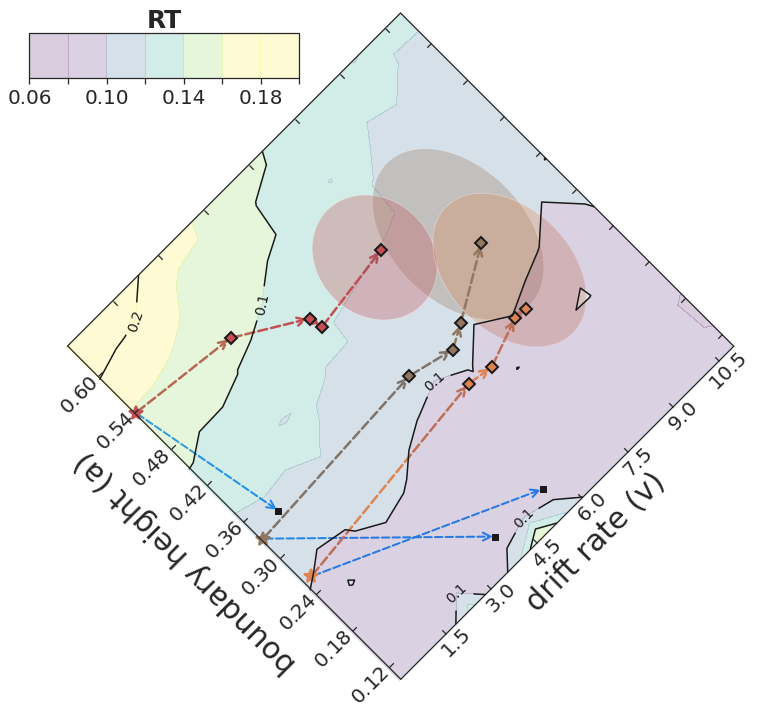

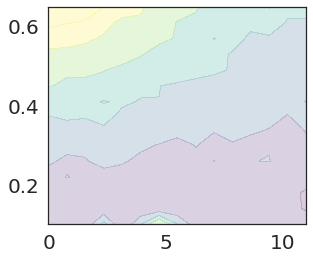

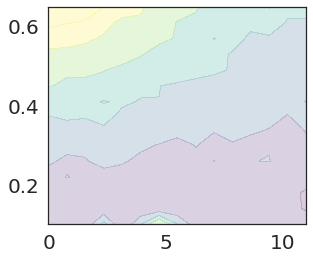

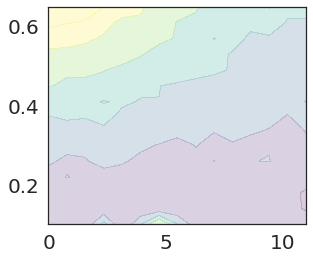

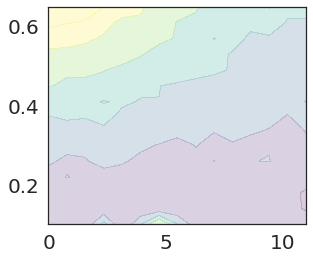

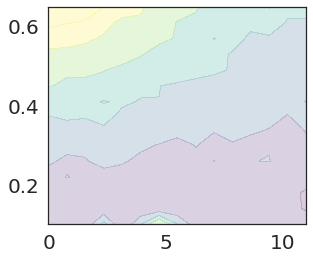

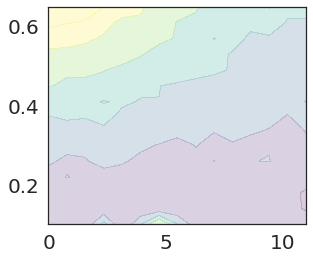

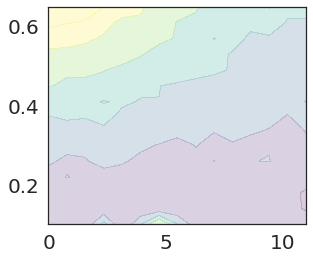

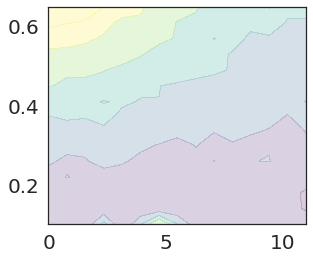

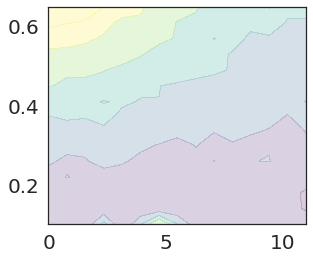

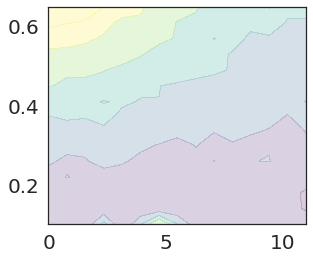

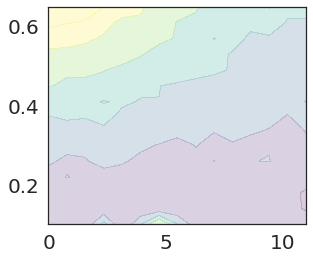

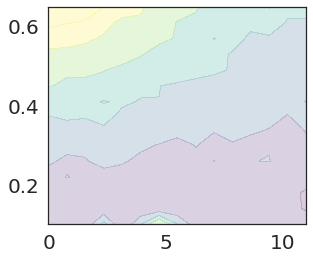

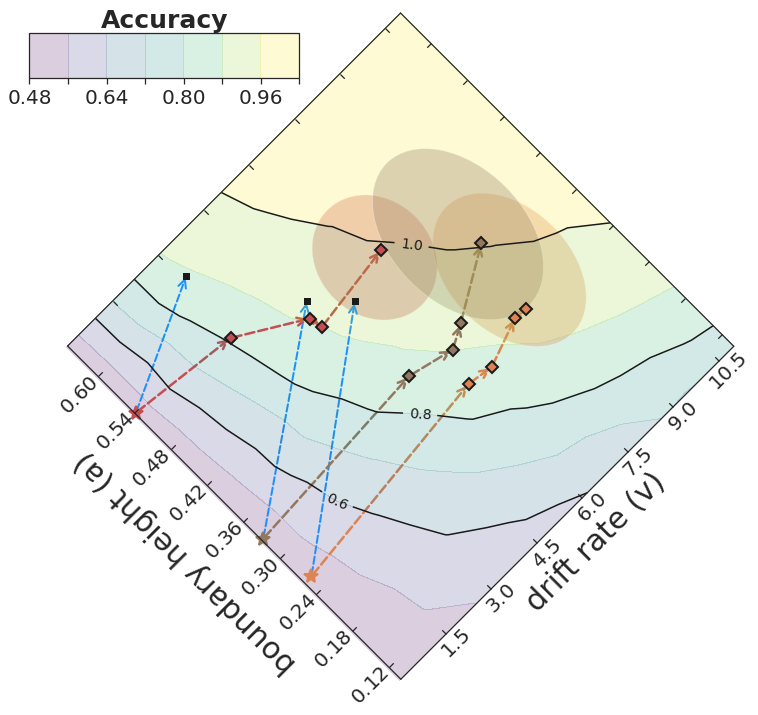

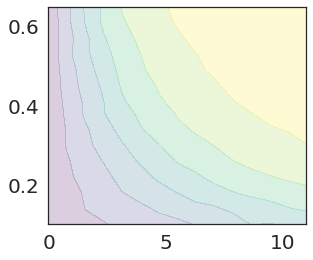

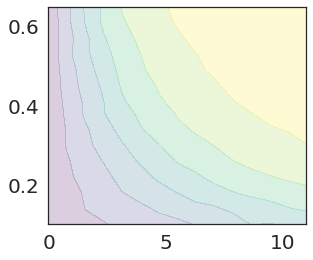

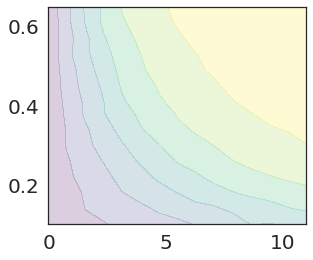

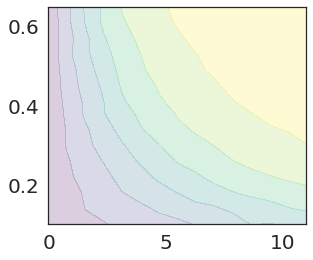

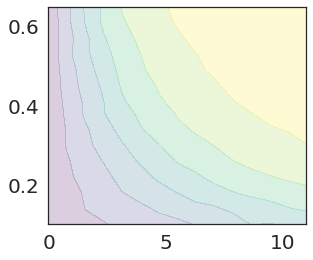

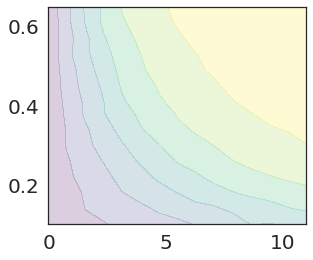

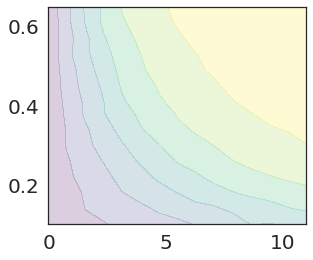

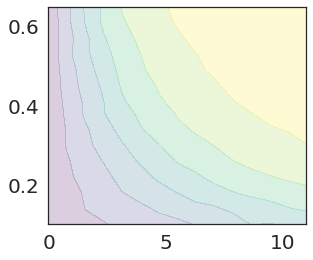

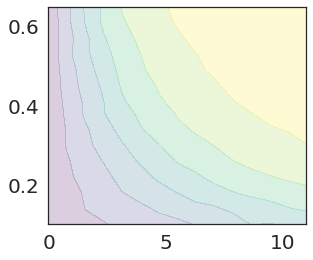

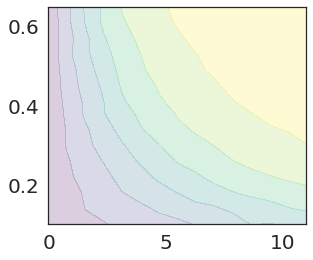

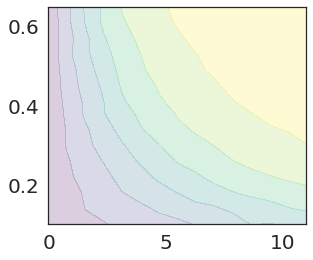

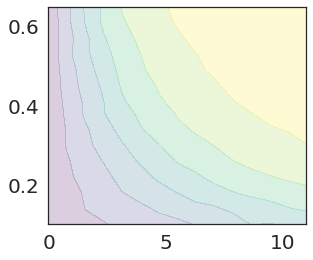

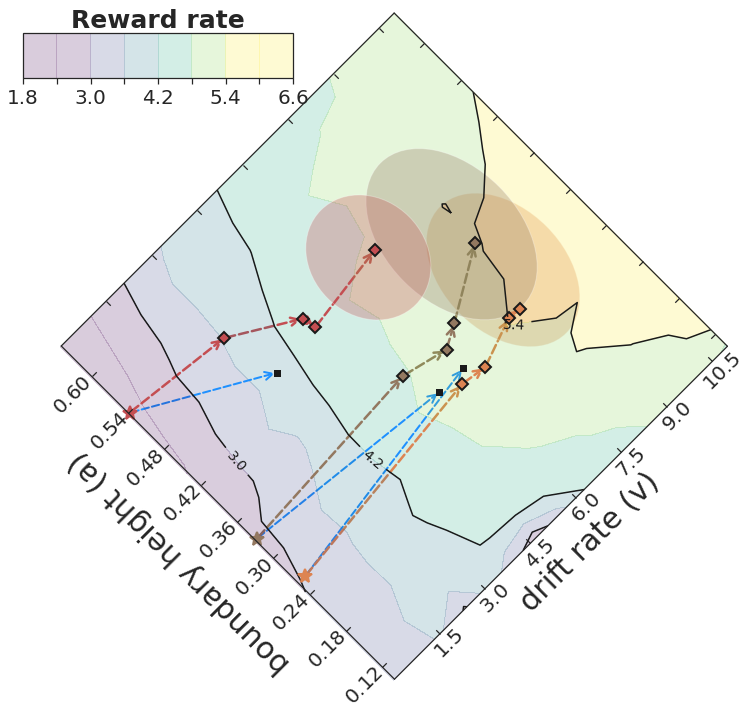

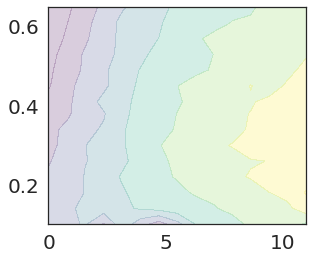

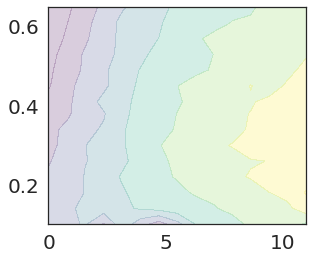

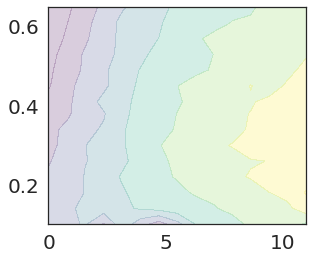

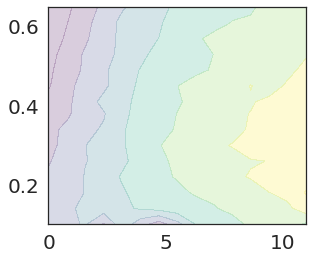

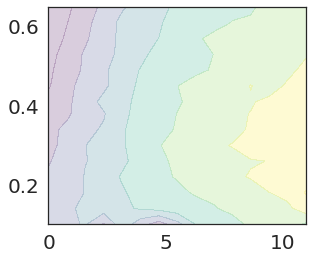

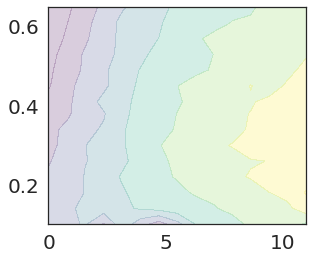

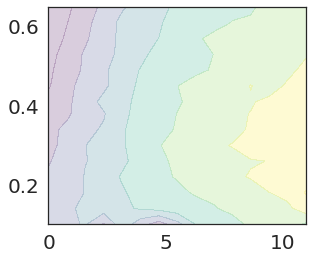

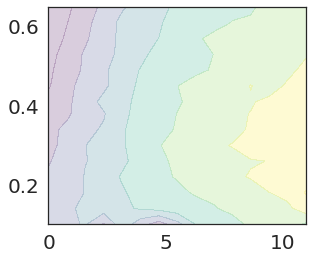

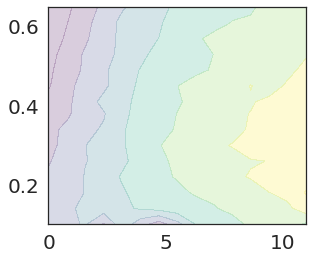

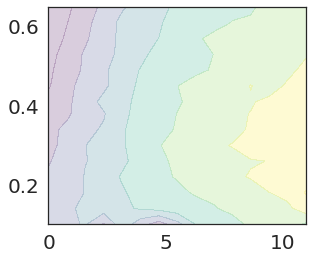

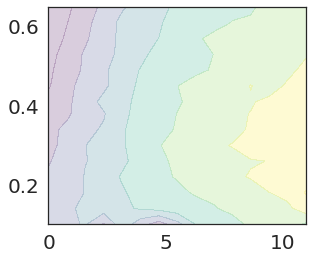

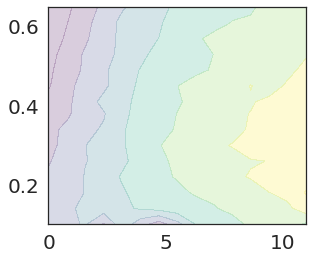

In [29]:
postfix = "local"
# postfix = "minimum"

fig_r,ax_r = plot_background_contour_rotated(X,Y,XY_rt,v_range,a_range,"RT")
rt_dist_from_optimal = plot_step_by_step_trajectory(ddm_params_stepwise,to_plot,ax_r,fig_r,XY_rt,v_range,a_range,"min","RT",postfix)
# fig_r.savefig(figure_dir+"RT_off_vs_on_contour_rotated_with_steps_"+postfix+".png", bbox_inches='tight')   
# fig_r.savefig(figure_dir+"RT_off_vs_on_contour_rotated_with_steps_"+postfix+".pdf", bbox_inches='tight')


fig_r1,ax_r1 = plot_background_contour_rotated(X,Y,XY_accuracy,v_range,a_range,"P(L)")
acc_dist_from_optimal = plot_step_by_step_trajectory(ddm_params_stepwise,to_plot,ax_r1,fig_r1,XY_accuracy,v_range,a_range,"max","P(L)",postfix)
# fig_r1.savefig(figure_dir+"accuracy_off_vs_on_contour_rotated_with_steps_"+postfix+".png", bbox_inches='tight')   
# fig_r1.savefig(figure_dir+"accuracy_off_vs_on_contour_rotated_with_steps_"+postfix+".pdf", bbox_inches='tight')   


fig_r2,ax_r2 = plot_background_contour_rotated(X,Y,XY_rr,v_range,a_range,"Reward rate")
rr_dist_from_optimal = plot_step_by_step_trajectory(ddm_params_stepwise,to_plot,ax_r2,fig_r2,XY_rr,v_range,a_range,"max","RR",postfix)
# fig_r2.savefig(figure_dir+"reward_rate_off_vs_on_contour_rotated_with_steps_"+postfix+".png", bbox_inches='tight')   
# fig_r2.savefig(figure_dir+"reward_rate_off_vs_on_contour_rotated_with_steps_"+postfix+".pdf", bbox_inches='tight')

In [30]:
cosine_distance_features = pd.DataFrame()
rt_dist_from_optimal_all_nws["feature_name"] = "RT"
acc_dist_from_optimal_all_nws["feature_name"] = "Accuracy"
rr_dist_from_optimal_all_nws["feature_name"] = "Reward rate"



cosine_distance_features = pd.concat([rt_dist_from_optimal_all_nws, acc_dist_from_optimal_all_nws, rr_dist_from_optimal_all_nws]).reset_index()
cosine_distance_features = cosine_distance_features.rename(columns={'cosine_distance':'cosine distance'})


/home/jyotika/Utils/envs/for_pymc3_python3.8_clean/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jyotika/Utils/envs/for_pymc3_python3.8_clean/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jyotika/Utils/envs/for_pymc3_python3.8_clean/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


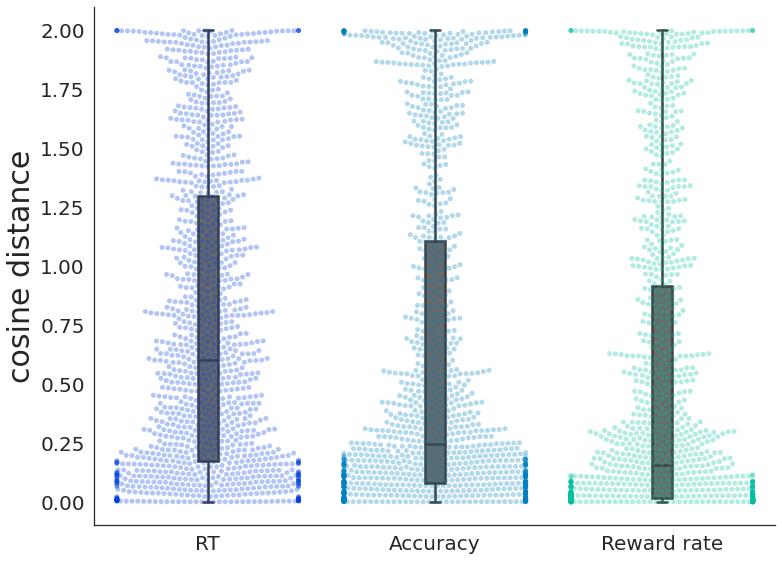

In [32]:
fig,ax = pl.subplots(1,1,figsize=(11,8))
plt.setp(ax.collections, alpha=.4)

sns.boxplot(data=cosine_distance_features,x="feature_name",y="cosine distance",color="dimgray", width=0.09,linewidth=2.5)
sns.swarmplot(x="feature_name",y="cosine distance",data=cosine_distance_features,ax=ax,s=5.0,alpha=0.3,palette='winter')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("")
plt.tight_layout()
fig.subplots_adjust(bottom=0.1,top=1.0,right=0.99,left=0.13)

## Statistics

In [33]:
for_stats = cosine_distance_features.copy()
for_stats = for_stats.rename(columns={'cosine distance':'cosine_distance'})

In [36]:
model = ols('cosine_distance ~ C(feature_name)', data=for_stats).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(feature_name),41.356173,2.0,47.208931,5.586645e-21
Residual,1670.140439,3813.0,NaN,NaN


## Figure S4 E

/home/jyotika/Utils/envs/for_pymc3_python3.8_clean/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jyotika/Utils/envs/for_pymc3_python3.8_clean/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jyotika/Utils/envs/for_pymc3_python3.8_clean/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jyotika/Utils/envs/for_pymc3_python3.8_clean/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripp

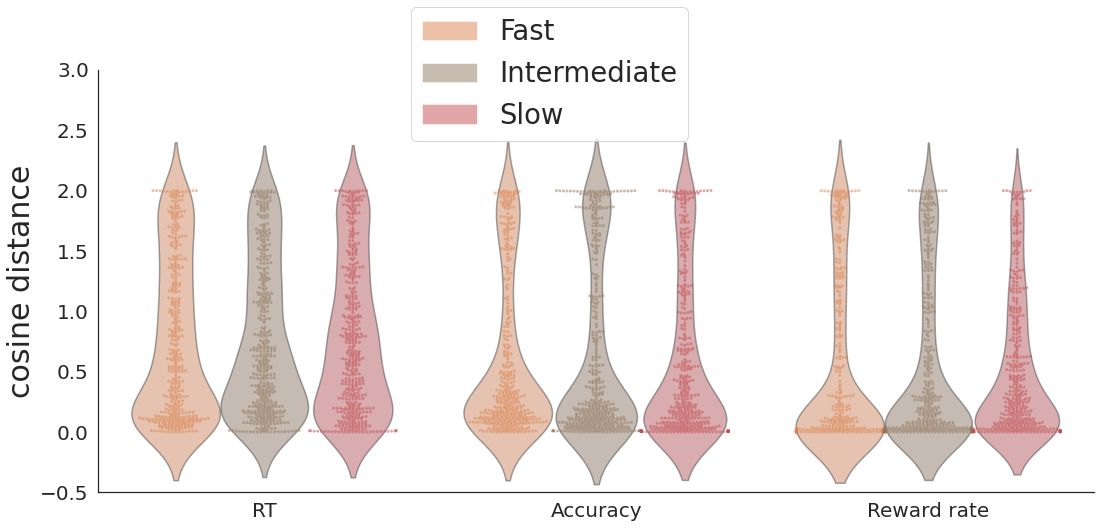

In [38]:
fig,ax = pl.subplots(1,1,figsize=(16,8))

sns.swarmplot(x="feature_name",y="cosine distance",data=cosine_distance_features,ax=ax,s=3,alpha=0.8,palette=colors_nw,hue='network_type',dodge=True)
sns.violinplot(x="feature_name",y="cosine distance",data=cosine_distance_features,hue='network_type',palette=colors_nw,alpha=0.5,ax=ax,inner=None)
plt.setp(ax.collections, alpha=.5)

plt.legend([], [], frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
custom_lines = [ Patch(facecolor=colors_nw[nt],  label=nt,alpha=0.5) for nt in nw_types]
ax.legend(custom_lines,nw_types,bbox_to_anchor=(0.3,0.8))
ax.set_xlabel("")
ax.set_ylim(-0.5,3.0)

plt.tight_layout()

## Figure S4 D

In [40]:
comp_rt_acc =  rt_dist_from_optimal_all_nws.merge(acc_dist_from_optimal_all_nws,on=["network_type","seed","state"])
comp_rt_rr =  rt_dist_from_optimal_all_nws.merge(rr_dist_from_optimal_all_nws,on=["network_type","seed","state"])
comp_rr_acc =  rr_dist_from_optimal_all_nws.merge(acc_dist_from_optimal_all_nws,on=["network_type","seed","state"])

comp_rt_acc = comp_rt_acc.rename(columns={'cosine_distance_x':'cosine_distance(RT)', 'cosine_distance_y':'cosine_distance(Accuracy)'})
comp_rt_rr = comp_rt_rr.rename(columns={'cosine_distance_x':'cosine_distance(RT)', 'cosine_distance_y':'cosine_distance(Reward rate)'})
comp_rr_acc = comp_rr_acc.rename(columns={'cosine_distance_x':'cosine_distance(Reward rate)', 'cosine_distance_y':'cosine_distance(Accuracy)'})




In [41]:
comp_rt_acc["RT - Accuracy"] = comp_rt_acc["cosine_distance(RT)"].values - comp_rt_acc["cosine_distance(Accuracy)"].values
comp_rt_rr["RT - Reward rate"] = comp_rt_rr["cosine_distance(RT)"].values - comp_rt_rr["cosine_distance(Reward rate)"].values
comp_rr_acc["Accuracy - Reward rate"] = comp_rr_acc["cosine_distance(Accuracy)"].values - comp_rr_acc["cosine_distance(Reward rate)"].values

to_plot_comparisons = pd.DataFrame()
to_plot_comparisons = comp_rt_acc.merge(comp_rt_rr,on=["network_type","seed","state"])
to_plot_comparisons = to_plot_comparisons.merge(comp_rr_acc,on =["network_type","seed","state"])

final_comparison = to_plot_comparisons[["network_type","seed","state","RT - Accuracy","RT - Reward rate","Accuracy - Reward rate"]]

In [42]:
final_comparison
final_comparison_melt = final_comparison.melt(id_vars=["network_type","seed","state"])
final_comparison_melt = final_comparison_melt.rename(columns={'value':'cosine distance'})

/home/jyotika/Utils/envs/for_pymc3_python3.8_clean/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jyotika/Utils/envs/for_pymc3_python3.8_clean/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


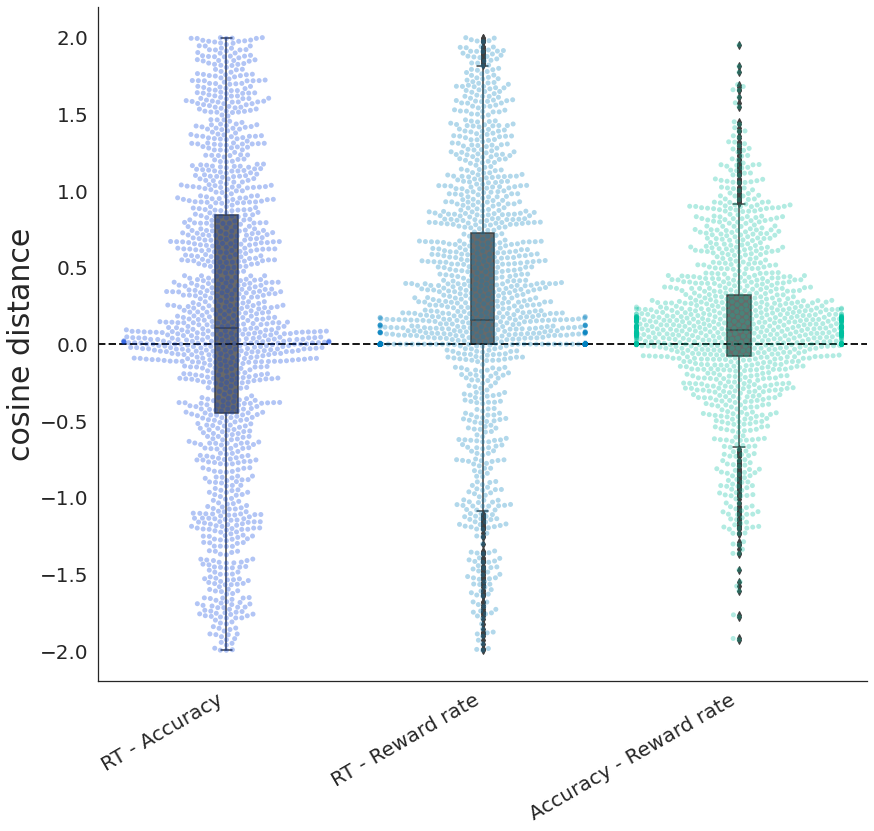

In [44]:
fig,ax = pl.subplots(1,1,figsize=(12,12))
sns.swarmplot(x="variable",y="cosine distance",data=final_comparison_melt,ax=ax,s=5,alpha=0.3,palette='winter')

sns.boxplot(x="variable",y="cosine distance",width=0.09,linewidth=1.5,color="dimgrey",data=final_comparison_melt) #palette='winter'


for x in ax.get_xticklabels():
    x.set_rotation(30)
    x.set_ha('right')
    # x.set_fontsize(25)
xlims = ax.get_xlim()
ax.hlines(y=0,xmin=xlims[0],xmax=xlims[1],color='k',ls='dashed',lw=2.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("")
plt.tight_layout()
fig.subplots_adjust(bottom=0.22,top=1.0,right=0.99,left=0.1)

### Statistics

In [45]:
df_sm = final_comparison_melt[["variable","cosine distance"]].copy()
df_sm = df_sm.rename(columns={'cosine distance':'value'})
model = ols('value ~ C(variable)', data=df_sm).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(variable),15.202832,2.0,12.518015,0.000004
Residual,2315.398924,3813.0,NaN,NaN


In [47]:
print(sp_st.ttest_1samp(comp_rt_acc["RT - Accuracy"].values,popmean=0.0))
print(sp_st.ttest_1samp(comp_rt_rr["RT - Reward rate"].values,popmean=0.0))
print(sp_st.ttest_1samp(comp_rr_acc["Accuracy - Reward rate"].values,popmean=0.0))


TtestResult(statistic=5.5621583029282515, pvalue=3.245212213626547e-08, df=1271)
TtestResult(statistic=11.545188138209427, pvalue=2.154491871346355e-29, df=1271)
TtestResult(statistic=7.07147569514726, pvalue=2.5234763237255614e-12, df=1271)
